In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('ggplot')
color='#702A7D'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

/opt/conda/lib/python3.10/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Define Query

In [4]:
lsoa_query = """
SELECT
  * 
FROM
    yhcr-prd-bradfor-bia-core.CB_2649.personLSOA
WHERE
    LSOA IS NOT NULL
"""

In [5]:
#LSOA data
lsoa_data = pandas_gbq.read_gbq(lsoa_query)

/opt/conda/lib/python3.10/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Downloading: 100%|██████████|


In [12]:
lsoa_data.head()

,person_id_hashed,ward,LSOA
0,006140F13A9D948D9CA1940C0556E333D6A545F22FE702...,None,
1,622466721BE2DB9987F3AAA709FC741EFD580E97E50C28...,None,
2,FF75A4CD6C2FB3AEA043F043F192C14A33F8E730CCAE08...,None,
3,F69E1980DF63F34BAFD51107B4F5F577531190D6B8DE8F...,None,
4,04405F056CD36009CF87D15057BFEC4D75FCF64A031913...,None,


In [13]:
# Information about the columns
lsoa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7356 entries, 0 to 7355
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   person_id_hashed  7356 non-null   object
 1   ward              6937 non-null   object
 2   LSOA              7356 non-null   object
dtypes: object(3)
memory usage: 172.5+ KB


In [19]:
# Count unique values in the LSOA column
lsoa_data.LSOA.value_counts()

LSOA
             96
E01010650    86
E01010739    84
E01010821    78
E01010745    71
             ..
E01010994     1
E01010993     1
E01000305     1
E01010962     1
E01011560     1
Name: count, Length: 719, dtype: int64

___________
Looks like we have rows that are empty but null. I'll remove the rows that are blank

In [21]:
lsoa_data = lsoa_data[lsoa_data['LSOA'].str.strip() != '']
lsoa_data.LSOA.value_counts()

LSOA
E01010650    86
E01010739    84
E01010821    78
E01010745    71
E01010736    69
             ..
E01010976     1
E01010974     1
E01008096     1
E01010958     1
E01005162     1
Name: count, Length: 718, dtype: int64

In [8]:
# Load Boundary Data

lsoa_boundaries = gpd.read_file('BradfordBoundaryData/england_lsoa_2021.shp')

In [9]:
lsoa_boundaries

,lsoa21cd,lsoa21nm,label,name,geometry
0,E01010709,Bradford 006D,E92000001E12000003E08000032E02002188E01010709,Bradford 006D,"POLYGON ((408633 442767, 408652 442765, 408657..."
1,E01010816,Bradford 057C,E92000001E12000003E08000032E02002239E01010816,Bradford 057C,"POLYGON ((421061.313 432163.812, 421060.567 43..."
2,E01010653,Bradford 026B,E92000001E12000003E08000032E02002208E01010653,Bradford 026B,"POLYGON ((418291.794 436882.905, 418293.188 43..."
3,E01010769,Bradford 003C,E92000001E12000003E08000032E02002185E01010769,Bradford 003C,"POLYGON ((416504.555 446664.136, 416508.882 44..."
4,E01010583,Bradford 018B,E92000001E12000003E08000032E02002200E01010583,Bradford 018B,"POLYGON ((412794.499 439404.594, 412793.813 43..."
...,...,...,...,...,...
307,E01010650,Bradford 027B,E92000001E12000003E08000032E02002209E01010650,Bradford 027B,"POLYGON ((419039.168 436191.528, 419078.636 43..."
308,E01010820,Bradford 052C,E92000001E12000003E08000032E02002234E01010820,Bradford 052C,"POLYGON ((419299.166 431037.216, 419294.937 43..."
309,E01033696,Bradford 049I,E92000001E12000003E08000032E02002231E01033696,Bradford 049I,"POLYGON ((411951.812 431152.689, 411964.781 43..."
310,E01010648,Bradford 001C,E92000001E12000003E08000032E02002183E01010648,Bradford 001C,"POLYGON ((406820.328 450140.19, 406821.197 450..."


In [22]:
lsoa_boundaries.dtypes

lsoa21cd      object
lsoa21nm      object
label         object
name          object
geometry    geometry
dtype: object

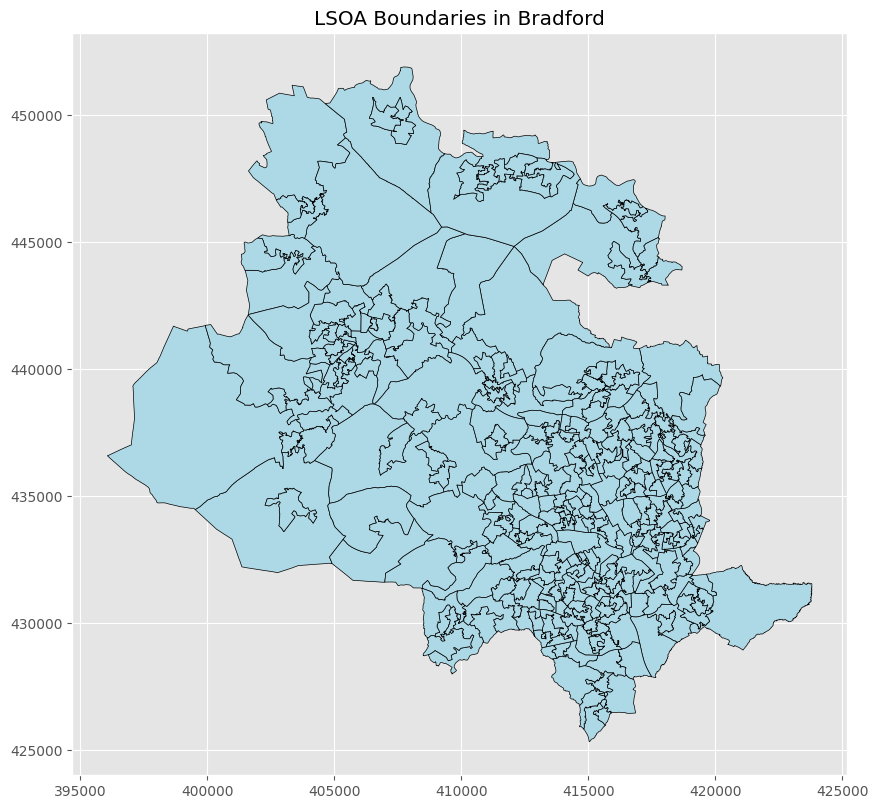

In [11]:
# Plot LSOA boundaries
lsoa_boundaries.plot(figsize=(10,10), color='lightblue', edgecolor='black')
plt.title('LSOA Boundaries in Bradford')
plt.show()

In [28]:
# Join both data
merged_data = lsoa_boundaries.merge(lsoa_data, left_on='lsoa21cd', right_on='LSOA', how='left')

In [30]:
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6389 entries, 0 to 6388
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   lsoa21cd          6389 non-null   object  
 1   lsoa21nm          6389 non-null   object  
 2   label             6389 non-null   object  
 3   name              6389 non-null   object  
 4   geometry          6389 non-null   geometry
 5   person_id_hashed  6361 non-null   object  
 6   ward              6089 non-null   object  
 7   LSOA              6361 non-null   object  
dtypes: geometry(1), object(7)
memory usage: 399.4+ KB
